In [1]:
using Distributions
using Random
using Roots
using StatsPlots
default(fmt = :png, size = (640, 400),
    titlefontsize = 10, plot_titlefont = 10)

In [2]:
function confdist(m, x̄, sx²)
    SEhat = √(sx²/m)
    x̄ + SEhat * TDist(m - 1)
end

function confdist(x)
    m, x̄, sx² = length(x), mean(x), var(x)
    confdist(m, x̄, sx²)
end

function tvalue(m, x̄, sx², μ = 0.0)
    (x̄ - μ) / √(sx²/m)
end

function tvalue(x, μ = 0.0)
    m, x̄, sx² = length(x), mean(x), var(x)
    tvalue(m, x̄, sx², μ)
end

function pvalue(m, x̄, sx², μ = 0.0)
    t = tvalue(m, x̄, sx², μ)
    ν = m - 1
    2ccdf(TDist(ν), abs(t))
end

function pvalue(x, μ = 0.0)
    m, x̄, sx² = length(x), mean(x), var(x)
    pvalue(m, x̄, sx², μ)
end

function confint(m, x̄, sx²; α = 0.05)
    ν = m - 1
    c = quantile(TDist(ν), 1-α/2)
    SEhat = √(sx²/m)
    [x̄ - c*SEhat, x̄ + c*SEhat]
end

function confint(x; α = 0.05)
    m, x̄, sx² = length(x), mean(x), var(x)
    confint(m, x̄, sx²; α)
end

function preddist(m, x̄, sx²)
    SEhat = √(sx²*(1+1/m))
    x̄ + SEhat * TDist(m - 1)
end

function preddist(x)
    m, x̄, sx² = length(x), mean(x), var(x)
    preddist(m, x̄, sx²)
end

function tvalue_pred(m, x̄, sx², xnew)
    (x̄ - xnew) / √(sx²*(1+1/m))
end

function tvalue_pred(x, xnew)
    m, x̄, sx² = length(x), mean(x), var(x)
    tvalue_pred(m, x̄, sx², xnew)
end

function pvalue_pred(m, x̄, sx², xnew)
    t = tvalue_pred(m, x̄, sx², xnew)
    ν = m - 1
    2ccdf(TDist(ν), abs(t))
end

function pvalue_pred(x, xnew)
    m, x̄, sx² = length(x), mean(x), var(x)
    pvalue_pred(m, x̄, sx², xnew)
end

function predint(m, x̄, sx²; α = 0.05)
    ν = m - 1
    c = quantile(TDist(ν), 1-α/2)
    SEhat = √(sx²*(1+1/m))
    [x̄ - c*SEhat, x̄ + c*SEhat]
end

function predint(x; α = 0.05)
    m, x̄, sx² = length(x), mean(x), var(x)
    confint_pred(m, x̄, sx²; α)
end

predint (generic function with 2 methods)

In [3]:
function logmaxlik(x)
    mle = fit_mle(Normal, x)
    loglikelihood(mle, x)
end

function maxlik(x)
    exp(logmaxlik(x))
end

function conditional_mle(x, μ)
    s = std(x; mean = μ, corrected = false)
    Normal(μ, s)
end

function conditional_logmaxlik(x, μ)
    cmle = conditional_mle(x, μ)
    loglikelihood(cmle, x)
end

function conditional_maxlik(x, μ)
    exp(conditional_logmaxlik(x, μ))
end

function logmaxlikrat(x, μ)
    conditional_logmaxlik(x, μ) - logmaxlik(x)
end

function maxlikrat(x, μ)
    exp(logmaxlikrat(x, μ))
end

function neg2loglikrat(x, μ)
    -2logmaxlikrat(x, μ)
end

function pvalue_loglikrat(x, μ)
    ccdf(Chisq(1), neg2loglikrat(x, μ))
end

function confint_loglikrat(x; α = 0.05)
    c = quantile(Chisq(1), 1 - α)
    ci = confint(x; α = α/10)
    find_zeros(μ -> neg2loglikrat(x, μ) - c, ci...)
end

confint_loglikrat (generic function with 1 method)

In [4]:
logmaxlikrat2pvalue(lmlr) = ccdf(Chisq(1), -2lmlr)
maxlikrat2pvalue(mlr) = ccdf(Chisq(1), -2log(mlr))
pvalue2logmaxlikrat(pval) = -quantile(Chisq(1), 1 - pval)/2
pvalue2maxlikrat(pval) = exp(pvalue2logmaxlikrat(pval))

pvalue2maxlikrat (generic function with 1 method)

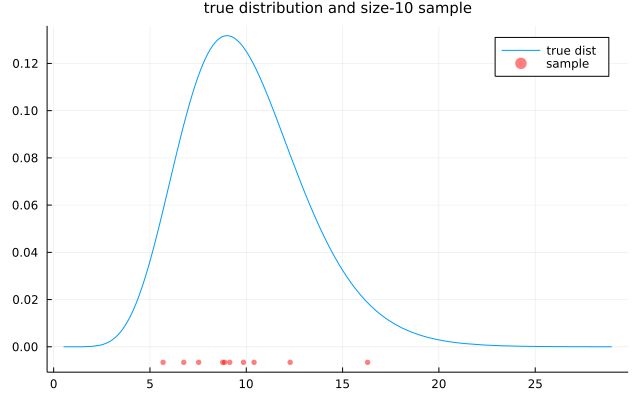

In [5]:
Random.seed!(4649373)

dist_true = Gamma(10, 1)
m = 10
x = rand(dist_true, m)

μ, σ = mean(dist_true), std(dist_true)
a, b = max(minimum(dist_true), μ-3σ), min(maximum(dist_true), μ+6σ)
plot(dist_true, a, b; label="true dist")
h = pdf(dist_true, mode(dist_true))
scatter!(x, fill(-0.05h, m); label="sample", ms=3, msc=:auto, alpha=0.5, c=:red)
title!("true distribution and size-$m sample")

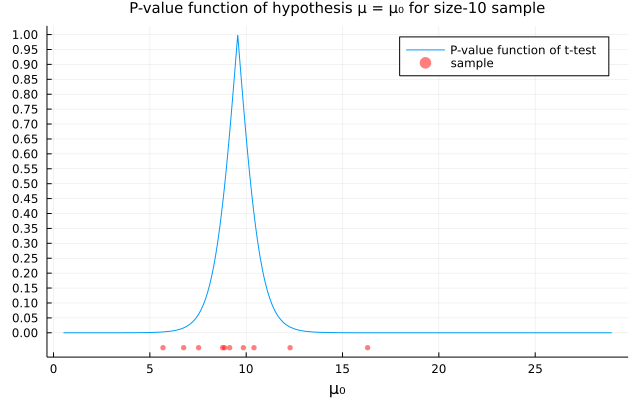

In [6]:
plot(μ₀ -> pvalue(x, μ₀), a, b; label="P-value function of t-test")
scatter!(x, fill(-0.05, m); label="sample", ms=3, msc=:auto, alpha=0.5, c=:red)
plot!(xguide="μ₀", ytick=0:0.05:1)
title!("P-value function of hypothesis μ = μ₀ for size-$m sample")

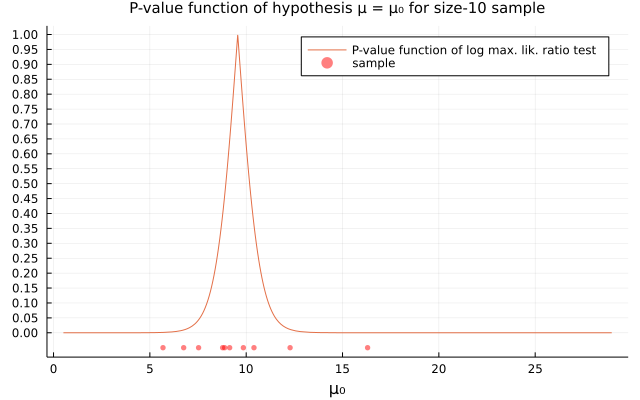

In [7]:
plot(μ₀ -> pvalue_loglikrat(x, μ₀), a, b; label="P-value function of log max. lik. ratio test", c=2)
scatter!(x, fill(-0.05, m); label="sample", ms=3, msc=:auto, alpha=0.5, c=:red)
plot!(xguide="μ₀", ytick=0:0.05:1)
title!("P-value function of hypothesis μ = μ₀ for size-$m sample")

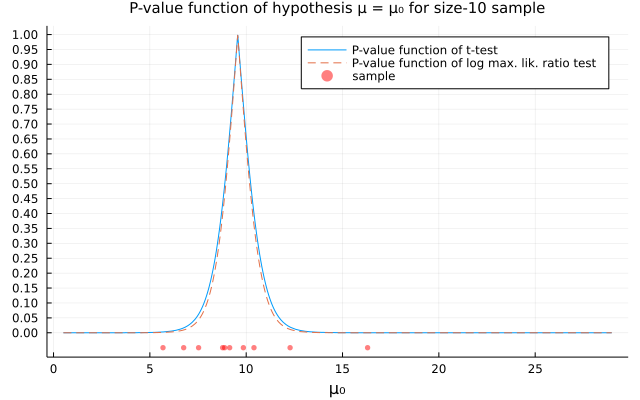

In [8]:
plot(μ₀ -> pvalue(x, μ₀), a, b; label="P-value function of t-test")
plot!(μ₀ -> pvalue_loglikrat(x, μ₀), a, b; label="P-value function of log max. lik. ratio test", c=2, ls=:dash)
scatter!(x, fill(-0.05, m); label="sample", ms=3, msc=:auto, alpha=0.5, c=:red)
plot!(xguide="μ₀", ytick=0:0.05:1)
title!("P-value function of hypothesis μ = μ₀ for size-$m sample")

ci = confint(x; α) = [7.402151477794028, 11.718580294539482]


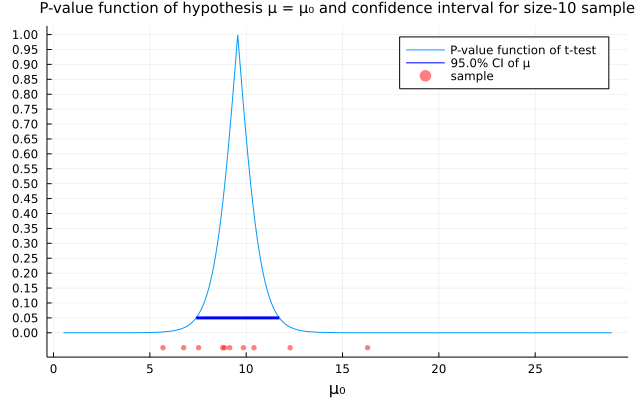

In [9]:
α = 0.05
@show ci = confint(x; α)

plot(μ₀ -> pvalue(x, μ₀), a, b; label="P-value function of t-test")
plot!(ci, fill(α, 2); label="$(100(1-α))% CI of μ", lw=3, c=:blue)
scatter!(x, fill(-0.05, m); label="sample", ms=3, msc=:auto, alpha=0.5, c=:red)
plot!(xguide="μ₀", ytick=0:0.05:1)
title!("P-value function of hypothesis μ = μ₀ and confidence interval for size-$m sample")

ci = confint_loglikrat(x; α) = [7.601598804244693, 11.519132968088815]


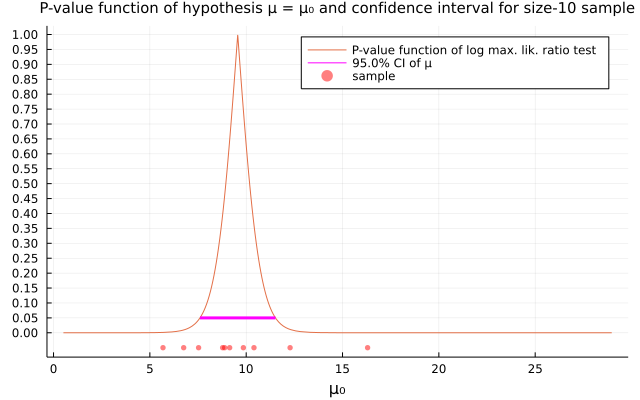

In [10]:
α = 0.05
@show ci = confint_loglikrat(x; α)

plot(μ₀ -> pvalue_loglikrat(x, μ₀), a, b; label="P-value function of log max. lik. ratio test", c=2)
plot!(ci, fill(α, 2); label="$(100(1-α))% CI of μ", lw=3, c=:magenta)
scatter!(x, fill(-0.05, m); label="sample", ms=3, msc=:auto, alpha=0.5, c=:red)
plot!(xguide="μ₀", ytick=0:0.05:1)
title!("P-value function of hypothesis μ = μ₀ and confidence interval for size-$m sample")

ci = confint_loglikrat(x; α) = [7.601598804244693, 11.519132968088815]


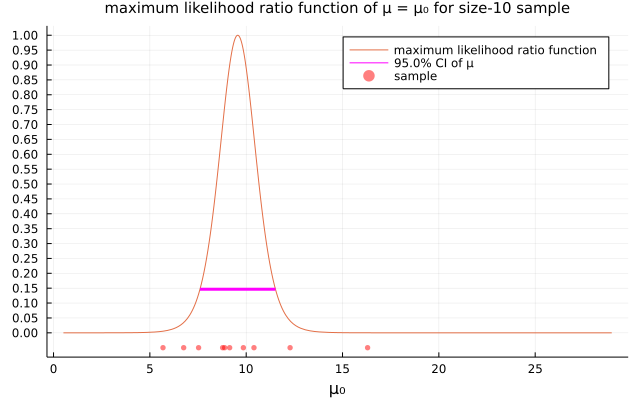

In [11]:
α = 0.05
@show ci = confint_loglikrat(x; α)

plot(μ₀ -> maxlikrat(x, μ₀), a, b; label="maximum likelihood ratio function", c=2)
c = quantile(Chisq(1), 1-α)
plot!(ci, fill(exp(-c/2), 2); label="$(100(1-α))% CI of μ", lw=3, c=:magenta)
scatter!(x, fill(-0.05, m); label="sample", ms=3, msc=:auto, alpha=0.5, c=:red)
plot!(xguide="μ₀", ytick=0:0.05:1)
title!("maximum likelihood ratio function of μ = μ₀ for size-$m sample")

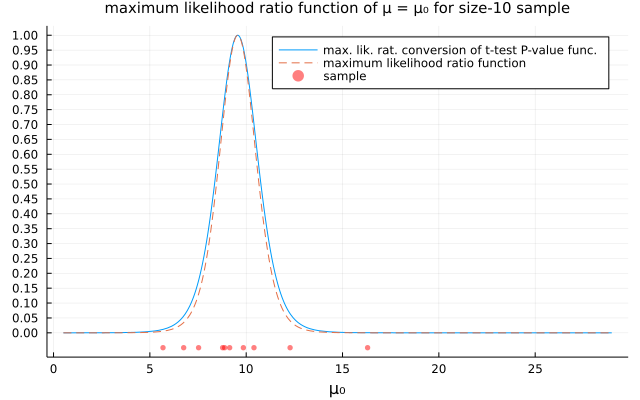

In [12]:
plot(μ₀ -> pvalue2maxlikrat(pvalue(x, μ₀)), a, b; label="max. lik. rat. conversion of t-test P-value func.")
plot!(μ₀ -> maxlikrat(x, μ₀), a, b; label="maximum likelihood ratio function", c=2, ls=:dash)
scatter!(x, fill(-0.05, m); label="sample", ms=3, msc=:auto, alpha=0.5, c=:red)
plot!(xguide="μ₀", ytick=0:0.05:1)
title!("maximum likelihood ratio function of μ = μ₀ for size-$m sample")

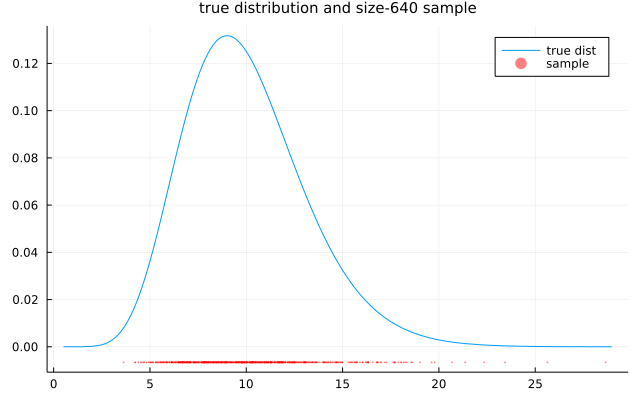

In [13]:
Random.seed!(4649373)

dist_true = Gamma(10, 1)
m = 640
x = rand(dist_true, m)

μ, σ = mean(dist_true), std(dist_true)
a, b = max(minimum(dist_true), μ-3σ), min(maximum(dist_true), μ+6σ)
plot(dist_true, a, b; label="true dist")
h = pdf(dist_true, mode(dist_true))
scatter!(x, fill(-0.05h, m); label="sample", ms=1, msc=:auto, alpha=0.5, c=:red)
title!("true distribution and size-$m sample")

ci = confint(x; α) = [9.944936454156132, 10.459949373863523]


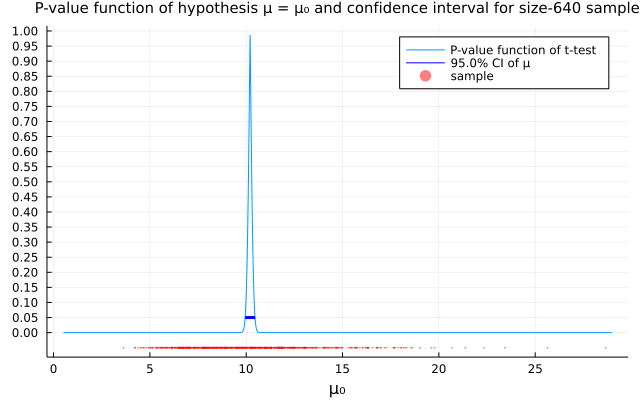

In [14]:
α = 0.05
@show ci = confint(x; α)

plot(μ₀ -> pvalue(x, μ₀), a, b; label="P-value function of t-test")
plot!(ci, fill(α, 2); label="$(100(1-α))% CI of μ", lw=3, c=:blue)
scatter!(x, fill(-0.05, m); label="sample", ms=1, msc=:auto, alpha=0.5, c=:red)
plot!(xguide="μ₀", ytick=0:0.05:1)
title!("P-value function of hypothesis μ = μ₀ and confidence interval for size-$m sample")

ci = confint_loglikrat(x; α) = [9.945239213979908, 10.459646614039961]


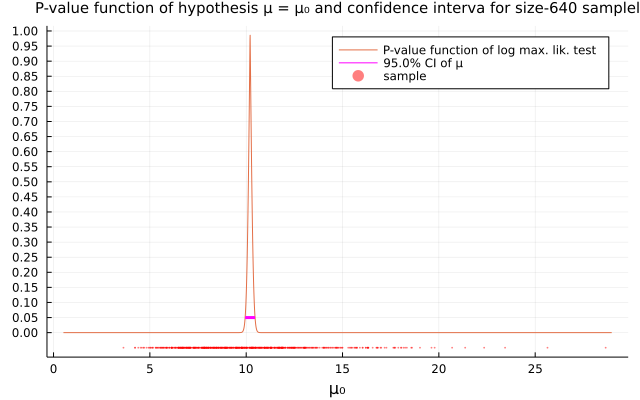

In [15]:
α = 0.05
@show ci = confint_loglikrat(x; α)

plot(μ₀ -> pvalue_loglikrat(x, μ₀), a, b; label="P-value function of log max. lik. test", c=2)
plot!(ci, fill(α, 2); label="$(100(1-α))% CI of μ", lw=3, c=:magenta)
scatter!(x, fill(-0.05, m); label="sample", ms=1, msc=:auto, alpha=0.5, c=:red)
plot!(xguide="μ₀", ytick=0:0.05:1)
title!("P-value function of hypothesis μ = μ₀ and confidence interva for size-$m samplel")

ci = confint_loglikrat(x; α) = [9.945239213979908, 10.459646614039961]


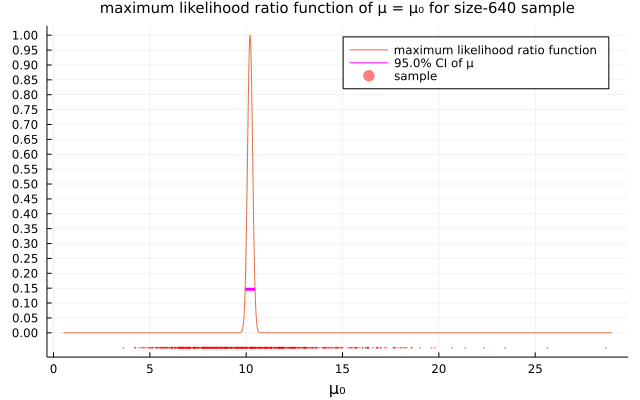

In [16]:
α = 0.05
@show ci = confint_loglikrat(x; α)

plot(μ₀ -> maxlikrat(x, μ₀), a, b; label="maximum likelihood ratio function", c=2)
c = quantile(Chisq(1), 1-α)
plot!(ci, fill(exp(-c/2), 2); label="$(100(1-α))% CI of μ", lw=3, c=:magenta)
scatter!(x, fill(-0.05, m); label="sample", ms=1, msc=:auto, alpha=0.5, c=:red)
plot!(xguide="μ₀", ytick=0:0.05:1)
title!("maximum likelihood ratio function of μ = μ₀ for size-$m sample")

In [17]:
function plot_ttest(;
        dist_true = Gamma(10, 1),
        m = 10,
        x = rand(dist_true, m))

    μ, σ = mean(dist_true), std(dist_true)
    a, b = max(minimum(dist_true), μ - 5σ), min(maximum(dist_true), μ + 5σ)

    P1 = plot(μ -> pvalue(x, μ), a, b; label="P-value")
    scatter!(x, fill(-0.05, length(x)); label="sample", ms=1.5, msc=:auto, alpha=0.5, c=:red)

    P2 = plot(xnew -> pdf(confdist(x), xnew), a, b; label="conf dist")
    h = pdf(confdist(x), mode(confdist(x)))
    scatter!(x, fill(-0.05h, length(x)); label="sample", ms=1.5, msc=:auto, alpha=0.5, c=:red)

    P3 = plot(xnew -> pvalue_pred(x, xnew), a, b; label="pred P-value")
    scatter!(x, fill(-0.05, length(x)); label="sample", ms=1.5, msc=:auto, alpha=0.5, c=:red)

    P4 = plot(xnew -> pdf(preddist(x), xnew), a, b; label="pred dist")
    plot!(dist_true, a, b; label="true dist", ls=:dash)
    h = pdf(preddist(x), mode(preddist(x)))
    scatter!(x, fill(-0.05h, length(x)); label="sample", ms=1.5, msc=:auto, alpha=0.5, c=:red)

    plot(P1, P2, P3, P4; size=(800, 500), layout=(2, 2))
    plot!(; plot_title="P-value function, etc. for size-$m sample of $(dist_true)")
end

plot_ttest (generic function with 1 method)

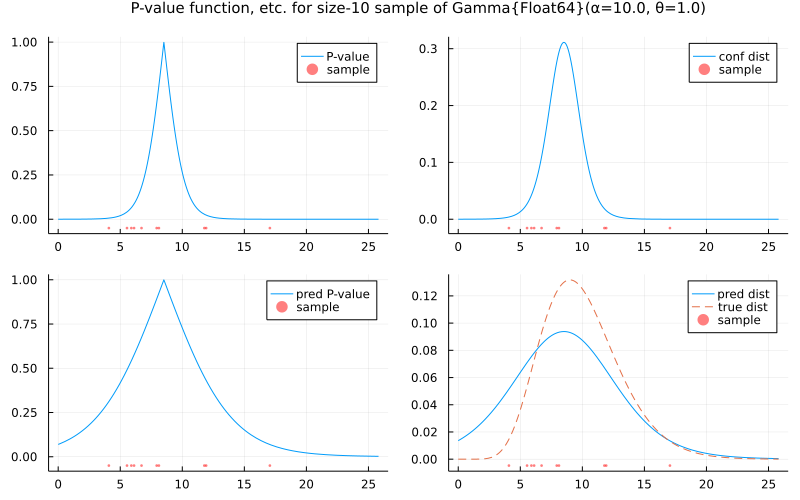

In [18]:
plot_ttest(m = 10)

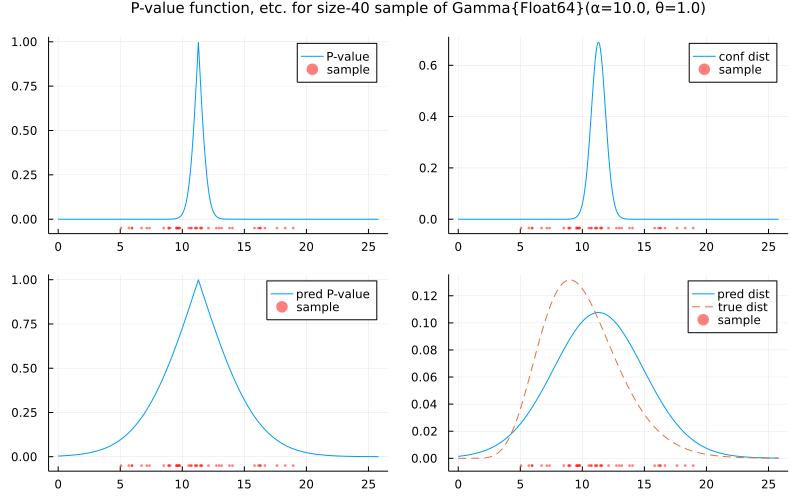

In [19]:
plot_ttest(m = 40)

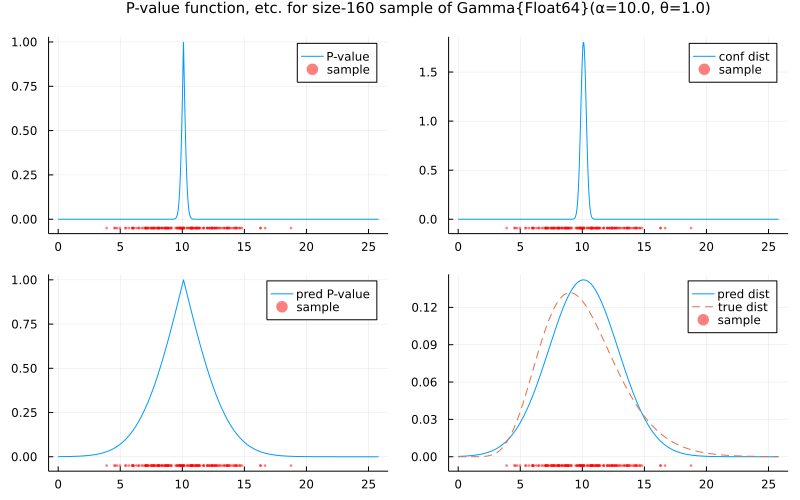

In [20]:
plot_ttest(m = 160)

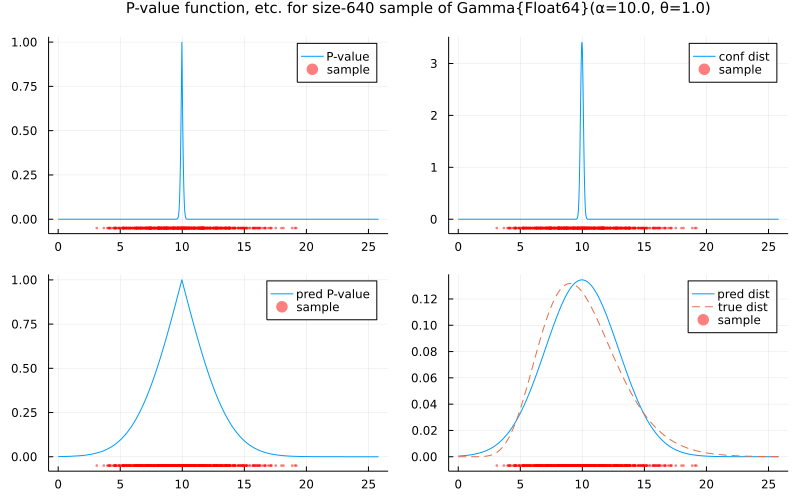

In [21]:
plot_ttest(m = 640)